## testing with south sudan UCDP data 

timeline for [south sudanese conflict](https://concernusa.org/news/timeline-south-sudan-history/)

methods should look at 2013-2015 and post peace process

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

data = pd.read_csv('../../data/ucdp/south_sudan.csv')
data.sort_values(by='date_start', inplace=True)

hm = pd.to_datetime(data['date_start']).dt.tz_localize('Africa/Juba').dt.tz_convert('UTC')

In [2]:
def create_sliding_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:(i + window_size)].values)
        y.append(data.iloc[i + window_size])
    return np.array(X), np.array(y)

In [3]:
window_size = 4  # 4-6 seems to be ideal
X, y = create_sliding_window(data['best'], window_size)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1018.0055073330528


In [6]:
y_test

array([  8,   2,  28,   5,  31,   2,   2,   3,  15,  14,  14,  36,   3,
         1,  40,   7,   2,   5,   5,  13,  13,  32,  36,   1,   3, 152,
       156,   2,   4,   3,   2,   5,  14,  30,   2,   6,  18,   3,   0,
         2,   0,  11,   3,   3,   2,   1,  10,   5,   5,   1,  16,  35,
         9,  50,   1,   1,   5,   9,   2,   3,   1,   1,  19,   2,   4,
         7,  16,   6,   0,   2,  16,  43,   5,   1,   6,  26,   9,   8,
         1,  20,   2,   6,   3,   0,   4,   2,  10,  15,   3,   3,   1,
         1,   7,   1,   5,  11,  15,  18,  82,   9,   4,  47,   3,   1,
         1,   2,   0,   0,  70,  10,   1, 238,  11,  37,   1,   4,   7,
         2,   1,   1,   1,  32,  25,   2,   7,   1,   1,   8,  24,   3,
        15,  29,  36,   5,   8,   2,   0,  26,  19,   3, 153,   3,   1,
         9,  24,   4,   0,   1,   0,   2,   4,   1,  42,   0,   1,   9,
         0,   2,   1,   3,   3,   0,   1,  17,  90,  13,   1,  11,   3,
         1,   3,   3,  11,   7,   0,   1,   0,   3,   3,   4,  9

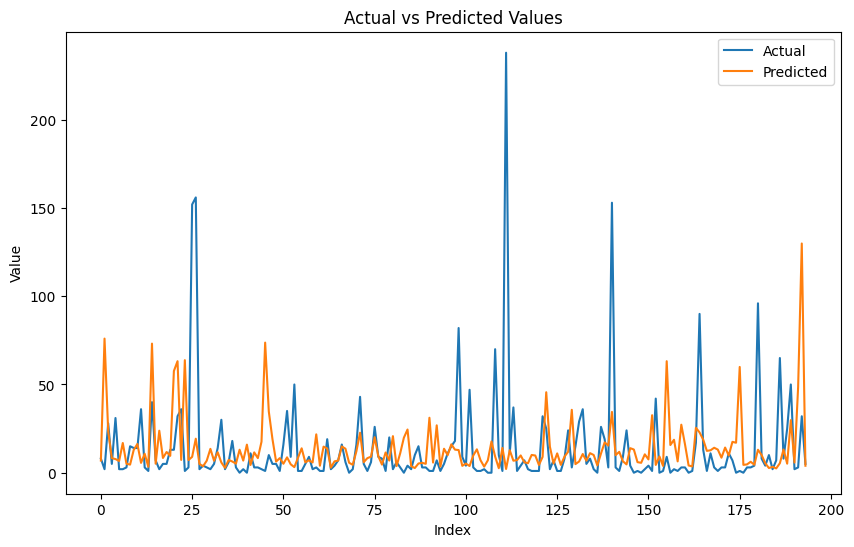

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()
